#### ML Assignment: Retail Project

**Problem statement**

- A retail company “ABC Private Limited” wants to understand the customer purchase
behaviour (specifically, purchase amount) against various products of different
categories. They have shared purchase summary of various customers for selected
high volume products from last month.

- The data set also contains customer demographics (age, gender, marital status,
city_type, stay_in_current_city), product details (product_id and product category) and
Total purchase_amount from last month.

- Now, they want to build a model to predict the purchase amount of customer against
various products which will help them to create personalized offer for customers
against different products

### Questions

1. Average Purchase amount?
2. Counting and Removing null values
3. How many distinct values per column?
4. Count category values within each of the following column:
-  Gender
- Age
- City_Category
- Stay_In_Current_City_Years
5. Calculate average Purchase for each of the following columns:
- Gender
- Age
- City_Category
- Stay_In_Current_City_Years
- Marital_Status
6. Label encode the following columns:
- Age
- Gender
- Stay_In_Current_City_Years
- City_Category
7. One-Hot encode following columns:
- Gender
- City_Category
- Occupation
8. Build a baseline model using any of the ML algorithms.
9. Model improvement with Grid-Search CV
10.Create a Spark ML Pipeline for the final model

#### Import Required Libraries

In [15]:
# importing the required libraries
from pyspark.sql import SparkSession
import pyspark.sql.types as tp
from pyspark.sql import functions as F

# libraries to make plots
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install cufflinks

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install chart-studio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [78]:
from pyspark.sql import SQLContext,Row
from pyspark import SparkContext
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
import pyspark.sql.functions as func
import pandas as pd
import plotly.graph_objs as go
import chart_studio.plotly as py

#For Interactive Plots
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
from plotly.offline import iplot


import pyspark
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#### Create Spark Session

In [20]:
spark = SparkSession.builder.getOrCreate()

/home/ana003162/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning:

Python 3.6 support is deprecated in Spark 3.2.



#### Reading the Data

In [21]:
# reading the train data
train_data = spark.read.csv("train.csv",inferSchema=True, header=True)

# reading the test data
test_data  = spark.read.csv("test.csv", inferSchema=True, header=True)

#### Data Exploration

1. Variable Identification
- Data Type of the columns

2. Perform Univariate and Bivariate Analysis

#### Variable Identification

In [22]:
# data type of the columns
train_data.printSchema()

root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- Purchase: integer (nullable = true)



** Numerical **

- User_ID
- Occupation 
- Marital_Status ( It is numerical in nature but still values are code representing different status like married or unmarried so we will treat it as categorical variable)
- Purchase
- Product_Category_1: integer (nullable = true)
- Product_Category_2: integer (nullable = true)
- Product_Category_3: integer (nullable = true)
- Purchase: integer (nullable = true)


** Categorical **

- Product_ID
- Gender
- Age
- City_Catgeory
- Stay_In_Current_City_Years




#### Check For  NULL Values in Each Column

In [23]:
### null values in each column
for c in train_data.columns:
    # define the condition
    missing_values = F.isnull(c)
    
    # filter the data with condition and count the number of data points
    missing_values = train_data.filter(missing_values).count()
    
    # print the result
    print(c, missing_values)

User_ID 0
Product_ID 0
Gender 0
Age 0
Occupation 0
City_Category 0
Stay_In_Current_City_Years 0
Marital_Status 0
Product_Category_1 0
Product_Category_2 173638
Product_Category_3 383247
Purchase 0


We have null values in only the following columns:
- Product_Category_2 173638
- Product_Category_3 383247

#### Distinct Values in Each Column

In [24]:
# distinct values in each column
# import count_distinct function 
from pyspark.sql.functions import count_distinct

# distinct value count in the Author and the Price columns 
train_data.select(count_distinct("User_ID"), count_distinct("Product_ID"), count_distinct("Gender"), count_distinct("Age"), count_distinct("Occupation"), count_distinct("City_Category"), 
count_distinct("Stay_In_Current_City_Years"), count_distinct("Marital_Status"), count_distinct("Product_Category_1"), count_distinct("Product_Category_2"), count_distinct("Product_Category_3")).show()


+-----------------------+--------------------------+----------------------+-------------------+--------------------------+-----------------------------+------------------------------------------+------------------------------+----------------------------------+----------------------------------+----------------------------------+
|count(DISTINCT User_ID)|count(DISTINCT Product_ID)|count(DISTINCT Gender)|count(DISTINCT Age)|count(DISTINCT Occupation)|count(DISTINCT City_Category)|count(DISTINCT Stay_In_Current_City_Years)|count(DISTINCT Marital_Status)|count(DISTINCT Product_Category_1)|count(DISTINCT Product_Category_2)|count(DISTINCT Product_Category_3)|
+-----------------------+--------------------------+----------------------+-------------------+--------------------------+-----------------------------+------------------------------------------+------------------------------+----------------------------------+----------------------------------+----------------------------------+
|   

#### Independant Variables Distribution

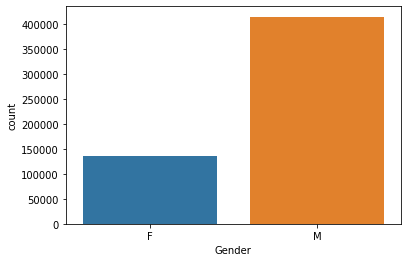

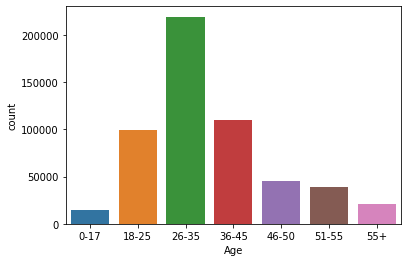

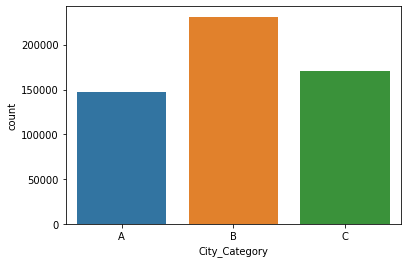

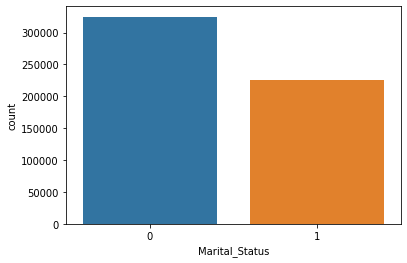

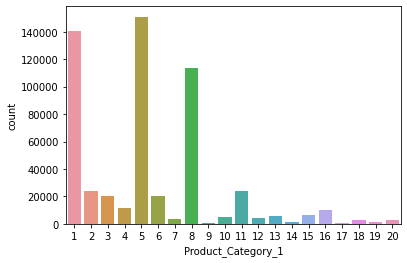

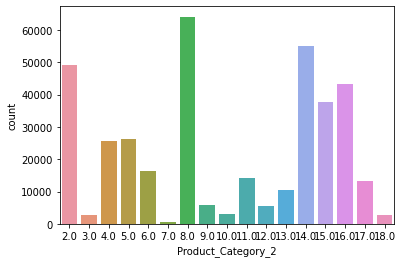

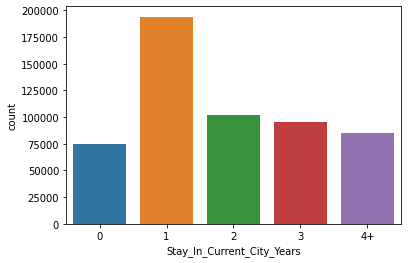

In [25]:
to_plot = ['Gender', 'Age', 'City_Category', 'Marital_Status', 
           'Product_Category_1','Product_Category_2', 'Stay_In_Current_City_Years']
for category in to_plot:
    temp_df = train_data.groupby(category).count().sort(category).toPandas()
    _ = sns.barplot(x = category, y = 'count', data = temp_df)
    plt.show()

In [26]:
temp_df = train_data.groupby(['Age', 'Gender']).count().sort('Age').toPandas()

In [27]:
pip install chart_studio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


#### Data Cleaning

In [28]:
# Not the most elegant solution, next steps is for a model to impute values
train_data = train_data.fillna(-1)
test_data = test_data.fillna(-1)

In [29]:
train_data.describe().show()

+-------+------------------+----------+------+------+-----------------+-------------+--------------------------+-------------------+------------------+------------------+------------------+-----------------+
|summary|           User_ID|Product_ID|Gender|   Age|       Occupation|City_Category|Stay_In_Current_City_Years|     Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|         Purchase|
+-------+------------------+----------+------+------+-----------------+-------------+--------------------------+-------------------+------------------+------------------+------------------+-----------------+
|  count|            550068|    550068|550068|550068|           550068|       550068|                    550068|             550068|            550068|            550068|            550068|           550068|
|   mean|1003028.8424013031|      null|  null|  null|8.076706879876669|         null|         1.468494139793958|0.40965298835780306| 5.404270017525106| 6.41976991935542

#### Column - Gneder

In [30]:
top_Gender = train_data.groupBy("Gender").agg(F.count("Gender").alias("Gender_count"))
top_Gender.show(10)

+------+------------+
|Gender|Gender_count|
+------+------------+
|     F|      135809|
|     M|      414259|
+------+------------+



In [31]:
# create list of top 10 Gender, you can change the parameter in the limit function to choose any other number of countries
top_10_Gender = (top_Gender.orderBy("Gender_count",ascending=False).limit(20).select("Gender").collect())
top_10_Gender = [ row.Gender for row in top_10_Gender]
print(top_10_Gender)

# define function to map Gender
def map_Gender(x):
    if x not in top_10_Gender:
        return "Others"
    else:
        return x

['M', 'F']


In [32]:
# Convert to udf function
map_Gender_udf = F.udf(f= map_Gender, returnType= tp.StringType())

In [33]:
# map Gender
train_data = train_data.withColumn("Gender_modified", map_Gender_udf(train_data["Gender"]))

In [34]:
# number of data points with gender category
top_10_Gender = train_data.groupBy("Gender_modified").agg(F.count("Gender_modified"))
top_10_Gender.show()

+---------------+----------------------+
|Gender_modified|count(Gender_modified)|
+---------------+----------------------+
|              F|                135809|
|              M|                414259|
+---------------+----------------------+



In [35]:
# test data
test_data = test_data.withColumn("Gender_modified", map_Gender_udf(test_data["Gender"]))

#### Column - Age

In [36]:
top_Age = train_data.groupBy("Age").agg(F.count("Age").alias("Age_count"))
top_Age.show(10)

+-----+---------+
|  Age|Age_count|
+-----+---------+
|18-25|    99660|
|26-35|   219587|
| 0-17|    15102|
|46-50|    45701|
|51-55|    38501|
|36-45|   110013|
|  55+|    21504|
+-----+---------+



In [37]:
# create list of top 10 Age, you can change the parameter in the limit function to choose any other number of countries
top_10_Age = (top_Age.orderBy("Age_count",ascending=False).limit(20).select("Age").collect())
top_10_Age = [ row.Age for row in top_10_Age]
print(top_10_Age)

# define function to map Gender
def map_Age(x):
    if x not in top_10_Age:
        return "Others"
    else:
        return x

['26-35', '36-45', '18-25', '46-50', '51-55', '55+', '0-17']


In [38]:
# Convert to udf function
map_Age_udf = F.udf(f= map_Age, returnType= tp.StringType())

In [39]:
# map Age
train_data = train_data.withColumn("Age_modified", map_Age_udf(train_data["Age"]))

In [40]:
# number of data points with Age category
top_10_Age = train_data.groupBy("Age_modified").agg(F.count("Age_modified"))
top_10_Age.show()

+------------+-------------------+
|Age_modified|count(Age_modified)|
+------------+-------------------+
|       18-25|              99660|
|       26-35|             219587|
|        0-17|              15102|
|       46-50|              45701|
|       51-55|              38501|
|       36-45|             110013|
|         55+|              21504|
+------------+-------------------+



In [41]:
# test data
test_data = test_data.withColumn("Age_modified", map_Gender_udf(test_data["Age"]))

#### Column - City_Category

In [42]:
top_citycategory = train_data.groupBy("City_Category").agg(F.count("City_Category").alias("City_Category_count"))
top_citycategory.show(10)

+-------------+-------------------+
|City_Category|City_Category_count|
+-------------+-------------------+
|            B|             231173|
|            C|             171175|
|            A|             147720|
+-------------+-------------------+



In [43]:
# create list of top 10 Gender, you can change the parameter in the limit function to choose any other number of countries
top_10_citycategory= (top_citycategory.orderBy("City_Category_count",ascending=False).limit(20).select("City_Category").collect())
top_10_citycategory = [ row.City_Category for row in top_10_citycategory]
print(top_10_citycategory)

# define function to map Gender
def map_City_Category(x):
    if x not in top_10_citycategory:
        return "Others"
    else:
        return x

['B', 'C', 'A']


In [44]:
# Convert to udf function
map_City_Category_udf = F.udf(f= map_City_Category, returnType= tp.StringType())

In [45]:
# map City_Category
train_data = train_data.withColumn("City_Category_modified", map_City_Category_udf(train_data["City_Category"]))

In [46]:
# number of data points with gender category
top_10_citycategory = train_data.groupBy("City_Category_modified").agg(F.count("City_Category_modified"))
top_10_citycategory.show()

+----------------------+-----------------------------+
|City_Category_modified|count(City_Category_modified)|
+----------------------+-----------------------------+
|                     B|                       231173|
|                     C|                       171175|
|                     A|                       147720|
+----------------------+-----------------------------+



In [47]:
# test data
test_data = test_data.withColumn("City_Category_modified", map_Gender_udf(test_data["City_Category"]))

#### Column - Stay_In_Current_City_Years

In [48]:
top_stayincurrentcityyears = train_data.groupBy("Stay_In_Current_City_Years").agg(F.count("Stay_In_Current_City_Years").alias("Stay_In_Current_City_Years_count"))
top_stayincurrentcityyears.show(10)

+--------------------------+--------------------------------+
|Stay_In_Current_City_Years|Stay_In_Current_City_Years_count|
+--------------------------+--------------------------------+
|                         3|                           95285|
|                         0|                           74398|
|                        4+|                           84726|
|                         1|                          193821|
|                         2|                          101838|
+--------------------------+--------------------------------+



In [49]:
# create list of top 10 Gender, you can change the parameter in the limit function to choose any other number of countries
top_10_stayincurrentcityyears = (top_stayincurrentcityyears.orderBy("Stay_In_Current_City_Years_count",ascending=False).limit(20).select("Stay_In_Current_City_Years").collect())
top_10_stayincurrentcityyears = [ row.Stay_In_Current_City_Years for row in top_10_stayincurrentcityyears]
print(top_10_stayincurrentcityyears)

# define function to map Gender
def map_Stay_In_Current_City_Years(x):
    if x not in top_10_stayincurrentcityyears:
        return "Others"
    else:
        return x

['1', '2', '3', '4+', '0']


In [50]:
# Convert to udf function
map_Stay_In_Current_City_Years_udf = F.udf(f= map_Stay_In_Current_City_Years, returnType= tp.StringType())

In [51]:
# map Stay_In_Current_City_Years
train_data = train_data.withColumn("Stay_In_Current_City_Years_modified", map_Stay_In_Current_City_Years_udf(train_data["Stay_In_Current_City_Years"]))

In [52]:
# number of data points with Stay_In_Current_City_Years category
top_10_stayincurrentcityyears = train_data.groupBy("Stay_In_Current_City_Years_modified").agg(F.count("Stay_In_Current_City_Years_modified"))
top_10_stayincurrentcityyears.show()

+-----------------------------------+------------------------------------------+
|Stay_In_Current_City_Years_modified|count(Stay_In_Current_City_Years_modified)|
+-----------------------------------+------------------------------------------+
|                                  3|                                     95285|
|                                  0|                                     74398|
|                                 4+|                                     84726|
|                                  1|                                    193821|
|                                  2|                                    101838|
+-----------------------------------+------------------------------------------+



In [53]:
# test data
test_data = test_data.withColumn("Stay_In_Current_City_Years_modified", map_Gender_udf(test_data["Stay_In_Current_City_Years"]))

#### Count Category Values with each of the columns: Gender, Age, Stay_In_Current_City_Years, City_Category

In [54]:
# each browser count in the dataset 
Gender = train_data.groupBy("Gender").agg(F.count("Gender"))
Gender.orderBy("count(Gender)",ascending=False).show(30)

+------+-------------+
|Gender|count(Gender)|
+------+-------------+
|     M|       414259|
|     F|       135809|
+------+-------------+



In [55]:
# each browser count in the dataset 
Gender = train_data.groupBy("Age").agg(F.count("Age"))
Gender.orderBy("count(Age)",ascending=False).show(30)

+-----+----------+
|  Age|count(Age)|
+-----+----------+
|26-35|    219587|
|36-45|    110013|
|18-25|     99660|
|46-50|     45701|
|51-55|     38501|
|  55+|     21504|
| 0-17|     15102|
+-----+----------+



In [56]:
# each browser count in the dataset 
Gender = train_data.groupBy("Stay_In_Current_City_Years").agg(F.count("Stay_In_Current_City_Years"))
Gender.orderBy("count(Stay_In_Current_City_Years)",ascending=False).show(30)

+--------------------------+---------------------------------+
|Stay_In_Current_City_Years|count(Stay_In_Current_City_Years)|
+--------------------------+---------------------------------+
|                         1|                           193821|
|                         2|                           101838|
|                         3|                            95285|
|                        4+|                            84726|
|                         0|                            74398|
+--------------------------+---------------------------------+



In [57]:
# each browser count in the dataset 
Gender = train_data.groupBy("City_Category").agg(F.count("City_Category"))
Gender.orderBy("count(City_Category)",ascending=False).show(30)

+-------------+--------------------+
|City_Category|count(City_Category)|
+-------------+--------------------+
|            B|              231173|
|            C|              171175|
|            A|              147720|
+-------------+--------------------+



#### Calculate average Purchase for each of the following columns: Gender, Age, Stay_In_Current_City_Years, City_Category, Marital_Status

In [58]:
## groupby to calculate average purchase for each of the columns 
avg_purchase = train_data.groupBy("Age").agg(F.count("Purchase").alias("avg_purchase"))
avg_purchase.show()

+-----+------------+
|  Age|avg_purchase|
+-----+------------+
|18-25|       99660|
|26-35|      219587|
| 0-17|       15102|
|46-50|       45701|
|51-55|       38501|
|36-45|      110013|
|  55+|       21504|
+-----+------------+



In [59]:
## groupby to calculate average purchase for each of the columns 
avg_purchase = train_data.groupBy("Gender").agg(F.count("Purchase").alias("avg_purchase"))
avg_purchase.show()

+------+------------+
|Gender|avg_purchase|
+------+------------+
|     F|      135809|
|     M|      414259|
+------+------------+



In [60]:
## groupby to calculate average purchase for each of the columns 
avg_purchase = train_data.groupBy("Stay_In_Current_City_Years").agg(F.count("Purchase").alias("avg_purchase"))
avg_purchase.show()

+--------------------------+------------+
|Stay_In_Current_City_Years|avg_purchase|
+--------------------------+------------+
|                         3|       95285|
|                         0|       74398|
|                        4+|       84726|
|                         1|      193821|
|                         2|      101838|
+--------------------------+------------+



In [61]:
## groupby to calculate average purchase for each of the columns 
avg_purchase = train_data.groupBy("City_Category").agg(F.count("Purchase").alias("avg_purchase"))
avg_purchase.show()

+-------------+------------+
|City_Category|avg_purchase|
+-------------+------------+
|            B|      231173|
|            C|      171175|
|            A|      147720|
+-------------+------------+



In [62]:
## groupby to calculate average purchase for each of the columns 
avg_purchase = train_data.groupBy("Marital_Status").agg(F.count("Purchase").alias("avg_purchase"))
avg_purchase.show()

+--------------+------------+
|Marital_Status|avg_purchase|
+--------------+------------+
|             1|      225337|
|             0|      324731|
+--------------+------------+



#### Label Encode following columns: Age, Gender, City_Category, Stay_In_Current_City_Years 

##### Label Encoding 

Assigning a unique integer to each of the categorical values Done using StringIndexer

In [63]:
# importing some more libraries
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

#### Create StringIndexer Objects

In [64]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(train_data) for column in list(set(["Age", "Gender","City_Category", "Stay_In_Current_City_Years", "Occupation"]))]


pipeline = Pipeline(stages=indexers)
train_data_new = pipeline.fit(train_data).transform(train_data)

train_data_new.show()

+-------+----------+------+-----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+---------------+------------+----------------------+-----------------------------------+---------+------------+----------------+-------------------+--------------------------------+
|User_ID|Product_ID|Gender|  Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Purchase|Gender_modified|Age_modified|City_Category_modified|Stay_In_Current_City_Years_modified|Age_index|Gender_index|Occupation_index|City_Category_index|Stay_In_Current_City_Years_index|
+-------+----------+------+-----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+--------+---------------+------------+----------------------+-----------------------------------+---------+------------+----------------+----------

#### Making transformation on test data

In [65]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(test_data) for column in list(set(["Age", "Gender","City_Category", "Stay_In_Current_City_Years", "Occupation"]))]

pipeline = Pipeline(stages=indexers)
test_data_new = pipeline.fit(test_data).transform(test_data)

test_data_new.show()

+-------+----------+------+-----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+---------------+------------+----------------------+-----------------------------------+---------+------------+----------------+-------------------+--------------------------------+
|User_ID|Product_ID|Gender|  Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|Gender_modified|Age_modified|City_Category_modified|Stay_In_Current_City_Years_modified|Age_index|Gender_index|Occupation_index|City_Category_index|Stay_In_Current_City_Years_index|
+-------+----------+------+-----+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+---------------+------------+----------------------+-----------------------------------+---------+------------+----------------+-------------------+-----------------

#### Making Product IDs into indexes

In [66]:
from pyspark.ml.feature import StringIndexer
plan_indexer = StringIndexer(inputCol = 'Product_ID', outputCol = 'productid')
labeller = plan_indexer.fit(train_data_new)

In [67]:
train1 = labeller.transform(train_data_new)
test1 = labeller.transform(test_data_new)

#### Prediction

#### Getting data reading for the model

In [68]:
from pyspark.ml.feature import RFormula
df_formula = "Purchase ~ Age+ Occupation +City_Category+Stay_In_Current_City_Years+Product_Category_1+Product_Category_2+ Product_Category_3 + Gender"
formula = RFormula(formula=df_formula,featuresCol="features",labelCol="label")

In [69]:
t1 = formula.fit(train1)
train_1 = t1.transform(train1)
test_1 = t1.transform(test1)

In [70]:
# See Results
train_1.select('features').show()
train_1.select('label').show()

+--------------------+
|            features|
+--------------------+
|(17,[6,10,13,14,1...|
|(17,[6,10,13,14,1...|
|(17,[6,10,13,14,1...|
|(17,[6,10,13,14,1...|
|(17,[5,6,8,12,13,...|
|(17,[0,6,11,13,14...|
|(17,[3,6,7,10,13,...|
|(17,[3,6,7,10,13,...|
|(17,[3,6,7,10,13,...|
|(17,[0,6,9,13,14,...|
|(17,[0,6,9,13,14,...|
|(17,[0,6,9,13,14,...|
|(17,[0,6,9,13,14,...|
|(17,[0,6,9,13,14,...|
|(17,[4,6,9,13,14,...|
|(17,[4,6,9,13,14,...|
|(17,[4,6,9,13,14,...|
|(17,[4,6,9,13,14,...|
|(17,[1,6,7,9,13,1...|
|(17,[0,6,8,12,13,...|
+--------------------+
only showing top 20 rows

+-------+
|  label|
+-------+
| 8370.0|
|15200.0|
| 1422.0|
| 1057.0|
| 7969.0|
|15227.0|
|19215.0|
|15854.0|
|15686.0|
| 7871.0|
| 5254.0|
| 3957.0|
| 6073.0|
|15665.0|
| 5378.0|
| 2079.0|
|13055.0|
| 8851.0|
|11788.0|
|19614.0|
+-------+
only showing top 20 rows



In [71]:
train_1.select('purchase').count()

550068

In [72]:
train_1.select('purchase').count()

550068

#### Model

In [73]:
train_cv, test_cv = train_1.randomSplit([0.7, 0.3])

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator()

In [75]:
    mean_se = []
    num_trees = []
    depth_type = []
    for trees in range(3,7):
        for depth in range(5,11):
            rf = RandomForestRegressor(numTrees=trees, maxDepth=depth, seed = 1)
            model_1 = rf.fit(train_cv)
            predictions = model_1.transform(test_cv)
            mse = evaluator.evaluate(predictions,{evaluator.metricName:"mse" })
            mean_se.append(np.sqrt(mse))
            num_trees.append(trees)
            depth_type.append(depth)

#### Grid Search

In [76]:
spark_grid_search = pd.DataFrame({'depth': depth, 'num_trees': num_trees, 'mean_se': mean_se})\
.sort_values('mean_se', ascending = True)[['depth', 'num_trees', 'mean_se']].reset_index(drop = True)

In [80]:
rf = RandomForestRegressor(numTrees=5, maxDepth=11, seed = 1)
model_1 = rf.fit(train_cv)
predictions = model_1.transform(test_cv)
mse = evaluator.evaluate(predictions,{evaluator.metricName:"mse" })

In [81]:
evaluator = RegressionEvaluator()
mse = evaluator.evaluate(predictions,{evaluator.metricName:"mse" })
import numpy as np
np.sqrt(mse), mse

(3320.145272090306, 11023364.627783613)

In [82]:
model = rf.fit(train_1)
predictions1 = model.transform(test_1)

In [83]:
df = predictions1.selectExpr("User_ID as User_ID", "Product_ID as Product_ID", 'prediction as Purchase')
df.toPandas().to_csv('black_friday_results.csv')